# DSA5101 ML Project - Bank Marketing Analysis
#### Contributors:
- Zhixin Lin (e0732596)
- Bowen Cai (e0732654)

## Brief Introduction about this project
- The data is related with direct marketing campaigns of a Portuguese banking institution.
- The classification goal is to predict if the client will subscribe a term deposit (variable y).

## Contents
0. **[Package-Prerequisites](#0.-Package-Prerequisites)**
1. **[Import data](#1.-Import-data)**
2. **[Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)**
3. **[Preprocessing](#3.-Preprocessing)**
4. **[Modeling](#4.-Modeling)**
5. **[Summary](#5.-Summary)**

## 0. Package Prerequisites
If you are using `conda`, please create an python environment and install the required packages with  
`conda create --name <env> --file conda_requirements.txt` (replace the `<env>` with the environment name you want)

If you are using `pip`, please install the required packages with  
`pip install numpy pandas matplotlib seaborn notebook scikit-learn imbalanced-learn` 

In [1]:
from calendar import month_abbr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# sampling
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
# preprocessing
from sklearn.preprocessing import MinMaxScaler
# cross validation
from sklearn.model_selection import GridSearchCV
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# model evaluation
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.metrics import classification_report, plot_roc_curve

## 1. Import data

In [3]:
df = pd.read_csv('./bank-full.csv',sep=';')

In [4]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [5]:
# Number of samples & features
df.shape

(45211, 17)

In [6]:
nume_inputs = ['age', 'balance', 'duration', 'day', 'campaign', 'pdays', 'previous']
cate_inputs = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
outputs = 'y'

In [7]:
# Check if there are null values
print(f'Any null value in the data: {df.isnull().any().any()}')

Any null value in the data: False


In [8]:
# For the convenience of following EDA, first map the response 'y' into {0, 1}
mapping_yn = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(mapping_yn)

## 2. Exploratory Data Analysis

### 2.1 Imbalance of data
- Given our data is imbalanced with the majority not subscribing a term deposit, we might want to do re-sampling to adjust the proportion while training

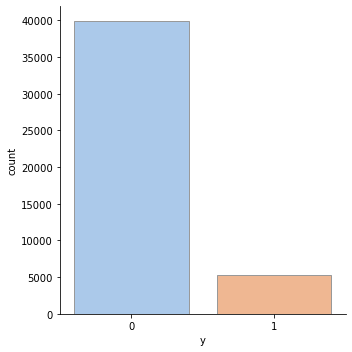

In [9]:
sns.catplot(x = 'y', kind = 'count', palette = 'pastel', edgecolor = '.6', data = df)

### 2.2 Examine categorical features

#### a) Unique values
- There're some binary variables such as 'default', 'housing', 'loan'. We might want to transform it for better predicting
- Although no NULL is detected, there are many 'unknown' values, which we should deal with when preprocessing
- There are a large percentage of unknown previous outcomes, which is not surprising because many customers don't have previous contacts (previous=0).

In [10]:
for col in cate_inputs:
    print('Unique "{}":\n {}'.format(col, df[col].unique()))

Unique "job":
 ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Unique "marital":
 ['married' 'single' 'divorced']
Unique "education":
 ['tertiary' 'secondary' 'unknown' 'primary']
Unique "default":
 ['no' 'yes']
Unique "housing":
 ['yes' 'no']
Unique "loan":
 ['no' 'yes']
Unique "contact":
 ['unknown' 'cellular' 'telephone']
Unique "month":
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Unique "poutcome":
 ['unknown' 'failure' 'other' 'success']


In [11]:
# The proportion of unknown value in each column
col_unknwn = ['job', 'education', 'contact', 'poutcome']
for col in col_unknwn:
    proportion = df[df[col]=='unknown'][col].count()/df[col].count()
    print('Unknown in column \"{}\": {:.1%}'.format(col, proportion))

Unknown in column "job": 0.6%
Unknown in column "education": 4.1%
Unknown in column "contact": 28.8%
Unknown in column "poutcome": 81.7%


#### b) Job
- The average 'y' for each job are all < 0.3
- Retired clients and students are more likely to subscribe among all the jobs

<AxesSubplot:xlabel='job'>

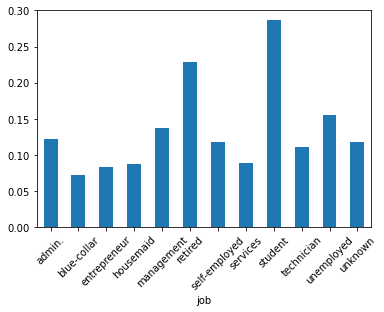

In [12]:
df.groupby('job').mean()['y'].plot.bar(rot=45)

#### c) Martial
- Single clients are a little bit more likely to subscribe

<AxesSubplot:xlabel='marital'>

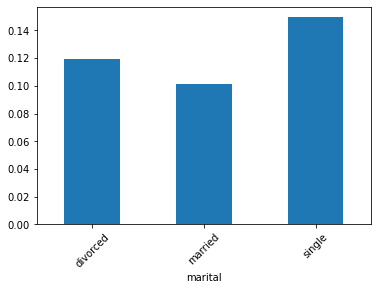

In [13]:
df.groupby('marital').mean()['y'].plot.bar(rot=45)

#### d) Education
- Clients with higher education level are more likely to subscribe.

<AxesSubplot:xlabel='education'>

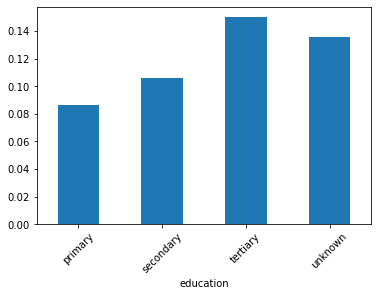

In [14]:
df.groupby('education').mean()['y'].plot.bar(rot=45)

#### e) Default
- Clients without credit in default are more likely to subscribe

<AxesSubplot:xlabel='default'>

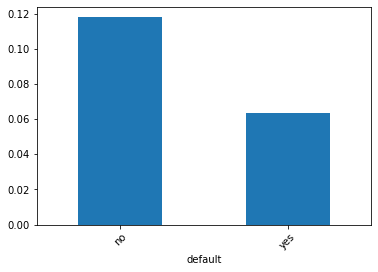

In [15]:
df.groupby('default').mean()['y'].plot.bar(rot=45)

#### f) Housing
- With housing loan, clients are less likey to subscribe

<AxesSubplot:xlabel='housing'>

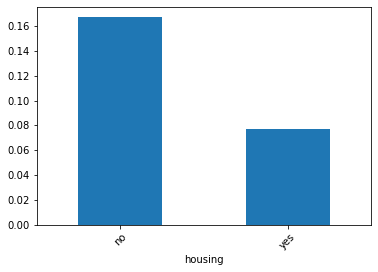

In [16]:
df.groupby('housing').mean()['y'].plot.bar(rot=45)

#### g) Loan
- Clients with personal loan are less likely to subscribe

<AxesSubplot:xlabel='loan'>

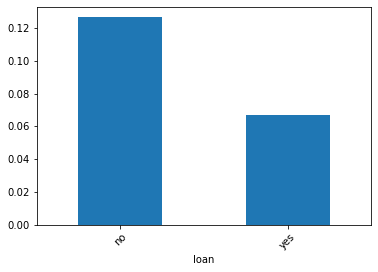

In [17]:
df.groupby('loan').mean()['y'].plot.bar(rot=45)

#### h) Contact
- The cellular and telephone contact have similar subscribing probability, but the prob of unknown is significantly lower

<AxesSubplot:xlabel='contact'>

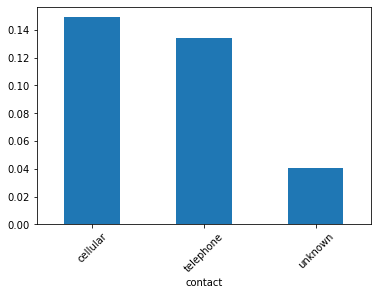

In [18]:
df.groupby('contact').mean()['y'].plot.bar(rot=45)

### 2.3 Look into numerical features

#### a) Age
- Majority (that's say 97pp or more) is <= 60
- Among those with age <= 60, the younger the clients are, the more likely that they are to subscribe

<AxesSubplot:xlabel='age', ylabel='Count'>

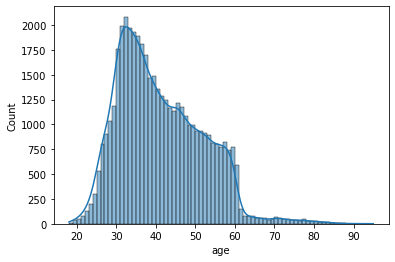

In [19]:
sns.histplot(df['age'], bins=len(df['age'].unique()), kde=True)

<AxesSubplot:xlabel='age'>

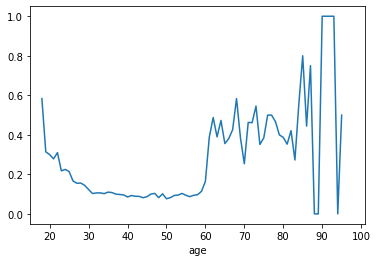

In [20]:
df.groupby('age').mean()['y'].plot(xlim=(15,101))

#### b) Balance
- Clients with negative balance seems to be less likely to subscribe

<AxesSubplot:xlabel='balance', ylabel='Count'>

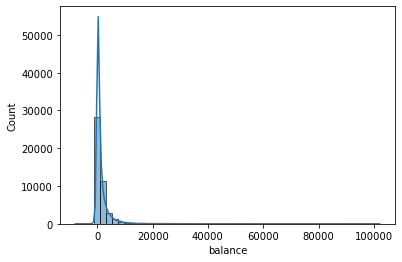

In [21]:
sns.histplot(df['balance'], bins=50, kde=True)

In [22]:
# quantiles of 'balance'
print(df.balance.quantile(.05))
print(df.balance.quantile(.95))

-172.0
5768.0


<AxesSubplot:xlabel='balance'>

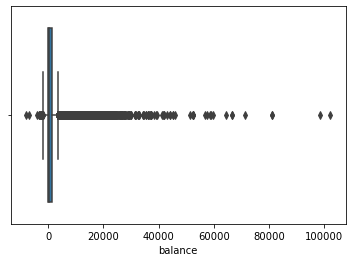

In [23]:
sns.boxplot(x=df.balance)

- Learn from the distribution as well as the boxplot results, 'balance' has many outliers
- So we try to limit the range and check balance again

In [24]:
# based on the 5% and 95% quantiles
df_balance_ranged = df[(df['balance'] < 6000) & (df['balance'] > -200)]

<AxesSubplot:xlabel='balance', ylabel='Count'>

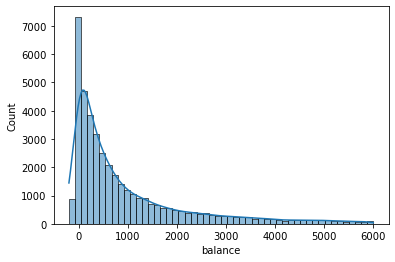

In [25]:
sns.histplot(df_balance_ranged.balance, bins=50, kde=True)

<AxesSubplot:xlabel='balance'>

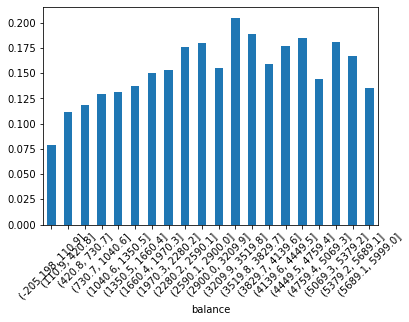

In [26]:
df_balance_ranged.groupby(pd.cut(df_balance_ranged['balance'], bins=20)).mean()['y'].plot.bar(rot=45)

#### c) Duration
- Client with longer last contact duration are more likely to subscribe
- Turn duration into minutes for easier understanding

<AxesSubplot:xlabel='duration', ylabel='Count'>

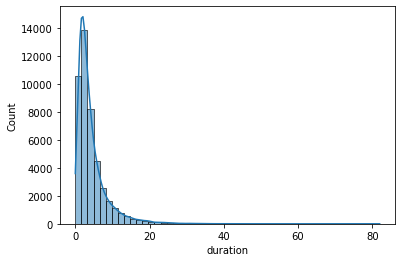

In [27]:
sns.histplot(df.duration / 60, bins=50, kde=True)

- Still many outliers

<AxesSubplot:xlabel='duration'>

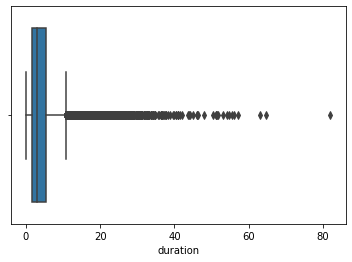

In [28]:
sns.boxplot(x=df.duration / 60)

- shown by the boxplot above, duration in min above 10~15 are regarded as outliers
- then we further check those below 15
- the below bar chart shows an increasing subscription probability of clients with longer contact duration

<AxesSubplot:xlabel='duration'>

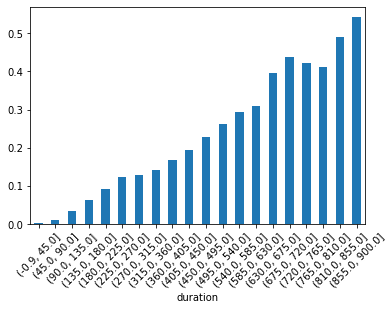

In [29]:
df_duration_ranged = df[df['duration'] /60 <= 15]
df_duration_ranged.groupby(pd.cut(df_duration_ranged['duration'], bins=20)).mean()['y'].plot.bar(rot=45)

#### d) Campaign
- Most clients only have 1 contact during this campaign

<AxesSubplot:xlabel='campaign', ylabel='Count'>

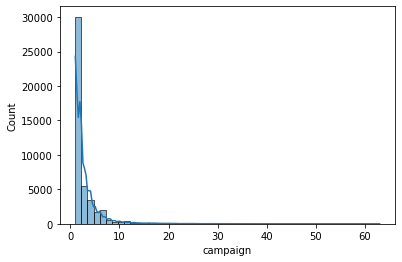

In [30]:
sns.histplot(df.campaign, bins=50, kde=True)

In [31]:
print(df.campaign.quantile(.95))
print(df.campaign.quantile(.99))

8.0
16.0


- As 'campaign' > 13 don't have enough samples, we just take those <= 13 for deep diving
- During this campaign, there's a trend that clients being contacted more are less and less likely to subscribe 

<AxesSubplot:xlabel='campaign'>

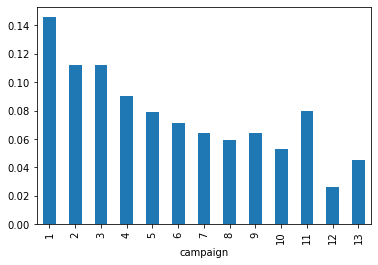

In [32]:
df[df['campaign'] <= 13].groupby('campaign').mean()['y'].plot.bar()

#### e) Pdays
- The majority of users did not have a last campaign

<AxesSubplot:xlabel='pdays', ylabel='Count'>

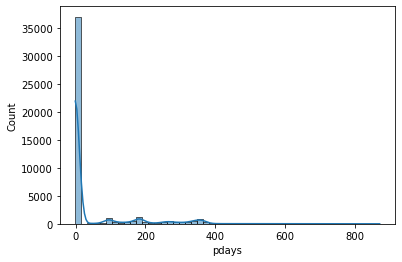

In [33]:
sns.histplot(df.pdays, bins=50, kde=True)

<AxesSubplot:xlabel='pdays', ylabel='Count'>

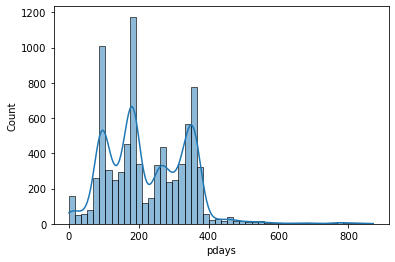

In [34]:
sns.histplot(df[df.pdays > -1].pdays, bins=50, kde=True)

#### f) Previous
- Distribution of 'previous' is also extremly skewed
- For the previous <= 10, clients with more previous campaigns are more likely to subscribe
- Only few clients have previous campaigns > 10 (less than 1pp of the sample)

<AxesSubplot:xlabel='previous', ylabel='Count'>

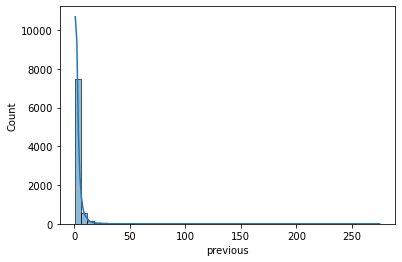

In [35]:
sns.histplot(df[df.previous > 0].previous, bins=50, kde=True)

In [36]:
print(df.previous.quantile(0.95))
print(df.previous.quantile(0.976))
print(df.previous.quantile(0.99))
print(df.previous.quantile(0.999))

3.0
5.0
8.900000000001455
22.0


<AxesSubplot:xlabel='previous', ylabel='Count'>

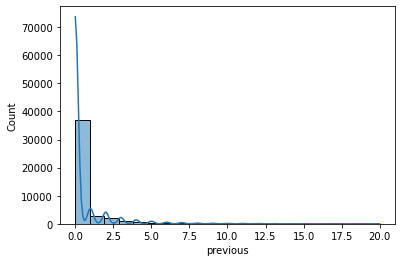

In [37]:
sns.histplot(df.loc[df.previous <= 20, 'previous'], 
             bins=len(df.loc[df.previous <= 20, 'previous'].unique()), kde=True)

<AxesSubplot:xlabel='previous'>

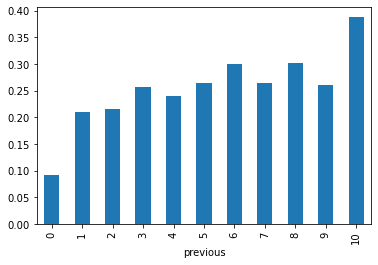

In [38]:
df[df['previous'] <= 10].groupby('previous').mean()['y'].plot.bar()

#### g) Month
- A subtle seasonality is shown.

<AxesSubplot:>

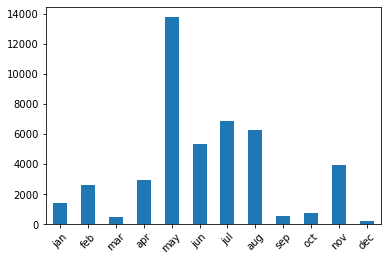

In [39]:
df['month'].value_counts().loc[list(map(lambda x: x.lower(), month_abbr))[1:]].plot.bar(rot=45)

<AxesSubplot:xlabel='month'>

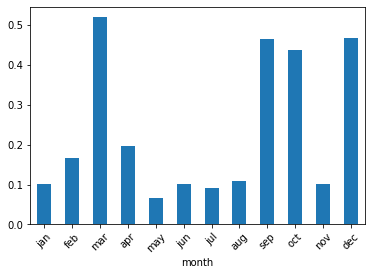

In [40]:
df.groupby('month').mean().loc[list(map(lambda x: x.lower(), month_abbr))[1:], 'y'].plot.bar(rot=45)

#### h) Day
- No correlation was found between day and customer subscription

<AxesSubplot:xlabel='day', ylabel='Count'>

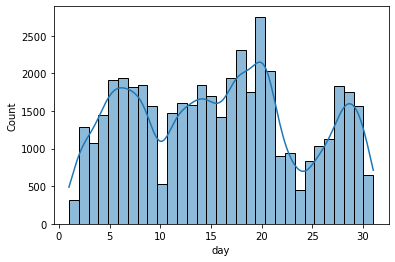

In [41]:
sns.histplot(df.day, bins=len(df['day'].unique()), kde=True)

<AxesSubplot:xlabel='day'>

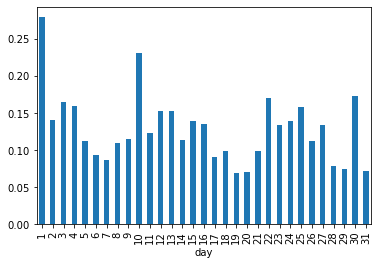

In [42]:
df.groupby('day').mean()['y'].plot.bar()

#### i) Correlation
- pdays & previous are correlated, while the rest are not considered correlated with each other.

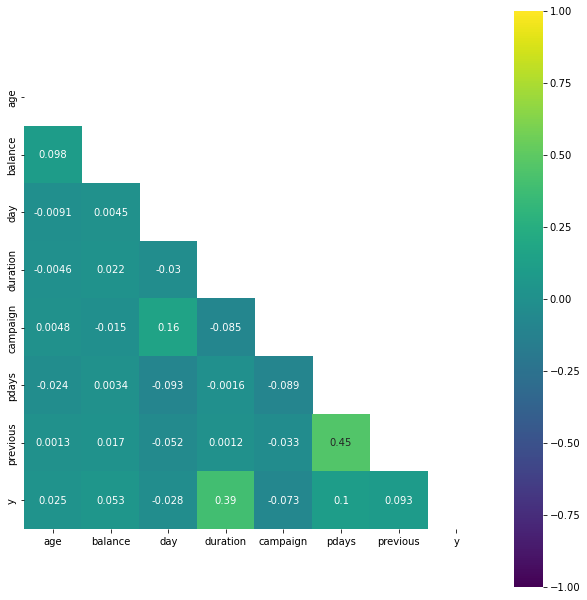

In [43]:
fig= plt.figure(figsize=(8,8))

corr = df.dropna().corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

## 3. Preprocessing

### 3.1 Process binary variables
- {"yes": 1, "no": 0}

In [44]:
mapping_yn = {'no': 0, 'yes': 1}
col_binary = ['default', 'housing', 'loan']
for col in col_binary:
    df[col] = df[col].map(mapping_yn)

### 3.2 Month
- From string to numbers

In [45]:
mapping_month = dict((month.lower(), number) for number, month in enumerate(month_abbr))
df['month'] = df['month'].map(mapping_month)

### 3.3 Education
- The education is ordinal and can be encoded as integers
- We will deal with the unknown values after train test split

In [46]:
edu_map = {'unknown':0, 'primary':1, 'secondary':2, 'tertiary':3}
df['education'] = df.education.map(edu_map).astype('int')

In [47]:
df.groupby('education').count()['y'].sort_values(ascending=False)

education
2    23202
3    13301
1     6851
0     1857
Name: y, dtype: int64

### 3.4 One-hot encoding
- Encode the nominal features with one-hot encoding

In [48]:
cols_dumm = ['job', 'marital', 'contact', 'poutcome']
df = pd.get_dummies(df, columns=cols_dumm)

In [49]:
# Remove the columns corresponding to unknown value
cols_onehot_unknown = [col for col in df.columns if 'unknown' in col]
df = df.drop(cols_onehot_unknown, axis=1)

In [50]:
col_features = list(df.columns)
col_features.remove('y')
col_target = 'y'

In [51]:
# Check current data set
pd.set_option('display.max_columns', None)
df.head(3)

,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
0,58,3,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,44,2,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,33,2,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### 3.5 Train Test Split
- Randomly select 20% of data set as test set

In [52]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1012, stratify=df[col_target])

In [53]:
X_train, y_train = df_train[col_features].copy(), df_train[col_target].copy()
X_test, y_test = df_test[col_features].copy(), df_test[col_target].copy()

In [54]:
print('Input size:')
print(f'Training Set: {X_train.shape}')
print(f'Test Set: {X_test.shape}')

Input size:
Training Set: (36168, 31)
Test Set: (9043, 31)


In [55]:
print('Output size:')
print(f'Training Set: {y_train.shape}')
print(f'Test Set: {y_test.shape}')

Output size:
Training Set: (36168,)
Test Set: (9043,)


### 3.6 Impute Education
- As there're around 4% of 'unknown' in education, we try to apply a basic random forest algorithm to fill them
- The random forest should only be trained on **training set**, because we should not gather information from test set

In [56]:
# Train RF imputer using data with known education
rf_imputer = RandomForestClassifier(random_state=1012)

In [57]:
# Use all features except 'education' to build model and predict 'education'
col_impute = col_features.copy()
col_impute.remove('education')
X_impute = X_train.loc[X_train['education'] != 0, col_impute]
y_impute = X_train.loc[X_train['education'] != 0, 'education']

In [58]:
# Check the performance of the imputer with cross validation within training set
cross_val_score(rf_imputer, X_impute, y_impute, cv=5, scoring='accuracy')

array([0.69381577, 0.70563644, 0.69900533, 0.71251442, 0.69867359])

In [59]:
# Use the whole training set with known education value to train the imputer
rf_imputer.fit(X=X_impute, y=y_impute)

RandomForestClassifier(random_state=1012)

In [60]:
# Transform the training set
X_train.loc[X_train['education'] == 0,'education'] \
    = rf_imputer.predict(X_train.loc[X_train['education'] == 0, col_impute])

# Transform the test set
X_test.loc[X_test['education'] == 0,'education'] \
    = rf_imputer.predict(X_test.loc[X_test['education'] == 0, col_impute])

### 3.7 Standardize
- For the algorithms that have implemented balanced class weights by scikit-learn, such as logistic regression, ridge classification and random forest, we can only standardize and don't oversample.

In [61]:
scaler = MinMaxScaler()

In [62]:
# Standarding (for algorithms that can apply balanced class weights)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.8 Oversampling
- For the algorithms that have not implemented balanced class weights by scikit-learn, we should manually oversample for a balanced data.
- Decision-tree-based algorithms do not require a standardization.

In [63]:
sm = SMOTE(random_state=1012)

In [64]:
# Only oversampling (for decision-tree-based algorithms and cannot apply balanced class weights)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [65]:
# Stardardized + Oversampling (for algorithms cannot apply balanced class weights)
X_train_scaled_sm, y_train_scaled_sm = sm.fit_resample(X_train_scaled, y_train)

### 3.9 Input Correlation
- Find if the input features have a strong correlation with each other
- Only features regarding previous campaign are highly correlated because most people does not have a previous previous campaign

<AxesSubplot:>

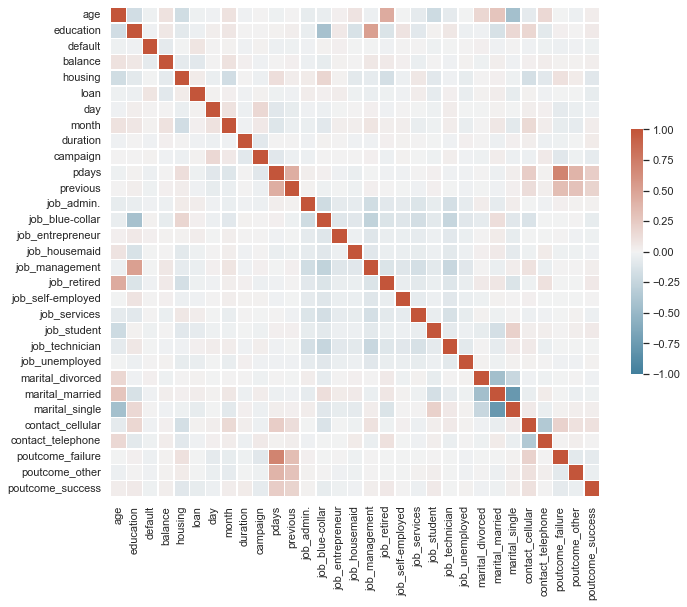

In [66]:
sns.set_theme(style="white")

# Compute the correlation matrix with pearson
corr = X_train.corr(method='pearson')

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 4. Modeling
- There're 4 preprocessed data ready to use
    1. X_train, X_test: only after basic transformation
    2. X_train_scaled, X_test_scaled: transform + standardize
    3. X_train_sm, X_test_sm: transform + oversampling
    4. X_train_scaled_sm, X_test_scaled_sm: transform + standardize + oversampling
- Using **5-fold cross validation** and **MCC score** to tune the hyper-parameters

In [67]:
# Make a MCC Scorer for GridSearchCV Hyper-parameter tuning
MCC_scorer = make_scorer(matthews_corrcoef)

### 4.1 Logistic Regression

#### a) Training

In [68]:
params_logistic = {'C': [0.1, 0.5, 1, 5, 10, 20, 40, 70, 100, 300, 500]}
clf_logistic = GridSearchCV(LogisticRegression(tol=1e-4, max_iter=10000, class_weight='balanced'), 
                            params_logistic, cv=5, scoring=MCC_scorer)

In [69]:
clf_logistic.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 20, 40, 70, 100, 300, 500]},
             scoring=make_scorer(matthews_corrcoef))

In [70]:
clf_logistic.best_params_

{'C': 1}

In [71]:
# Best cross validation score
print(f'5-Fold cross validation score: {clf_logistic.best_score_:.4f}')

5-Fold cross validation score: 0.4773


#### b) Performance on test set

In [72]:
pred_logistic = clf_logistic.predict(X_test_scaled)

In [73]:
print(classification_report(y_test, pred_logistic))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.79      0.51      1058

    accuracy                           0.83      9043
   macro avg       0.67      0.81      0.70      9043
weighted avg       0.90      0.83      0.85      9043



In [74]:
mcc_logistic = matthews_corrcoef(y_test, pred_logistic)
print(f'MCC of Logistic Regression: {mcc_logistic:.4f}')

MCC of Logistic Regression: 0.4654


#### c) Coefficients in model

<AxesSubplot:title={'center':'Coefficients in logistic regression model'}, xlabel='feature'>

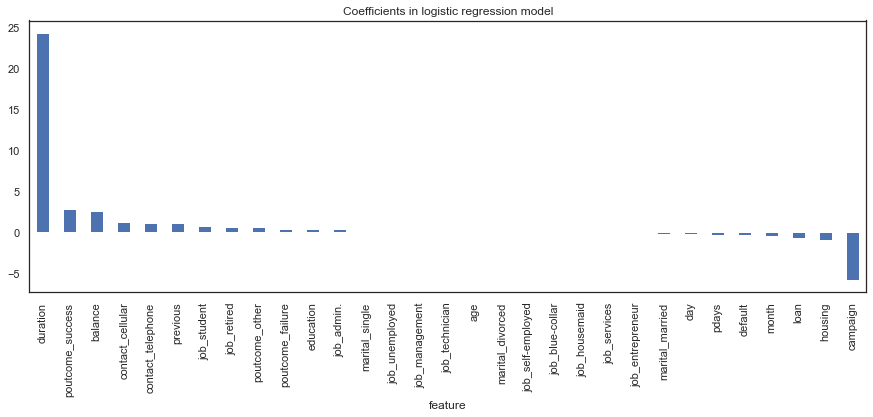

In [75]:
# Get the coefficients to see the contribution of each feature
coef_logistic = pd.DataFrame({'feature': col_features, 'coef': clf_logistic.best_estimator_.coef_[0]})\
    .sort_values('coef', ascending=False).reset_index(drop=True)
coef_logistic.plot(kind='bar', x='feature', y='coef',
                   title='Coefficients in logistic regression model', legend=False, 
                   figsize=(15,5))

<AxesSubplot:title={'center':'Coefficients in logistic regression model'}, xlabel='feature'>

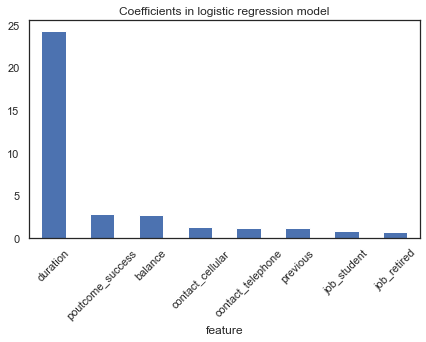

In [76]:
# The most positive features
coef_logistic.iloc[0:8].plot(kind='bar', x='feature', y='coef', rot=45,
                   title='Coefficients in logistic regression model', legend=False, 
                   figsize=(7,4))

<AxesSubplot:title={'center':'Coefficients in logistic regression model'}, xlabel='feature'>

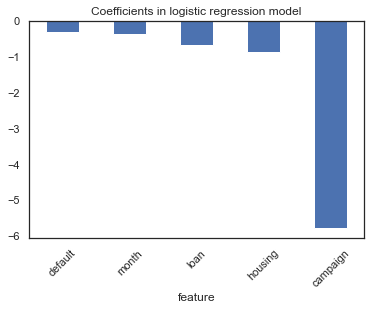

In [77]:
# The most negative features
coef_logistic.iloc[-5:].plot(kind='bar', x='feature', y='coef', rot=45,
                   title='Coefficients in logistic regression model', legend=False, 
                   figsize=(6,4))

### 4.2 Ridge Classifier

#### a) Training

In [78]:
params_ridge = {'alpha': [ 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]}
clf_ridge = GridSearchCV(RidgeClassifier(tol=1e-4, class_weight='balanced'), 
                         params_ridge, cv=5, scoring=MCC_scorer)

In [79]:
clf_ridge.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RidgeClassifier(class_weight='balanced', tol=0.0001),
             param_grid={'alpha': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1]},
             scoring=make_scorer(matthews_corrcoef))

In [80]:
clf_ridge.best_params_

{'alpha': 0.1}

In [81]:
# Best cross validation score
print(f'5-Fold cross validation score: {clf_ridge.best_score_:.4f}')

5-Fold cross validation score: 0.4784


#### b) Performance on test set

In [82]:
pred_ridge = clf_ridge.predict(X_test_scaled)

In [83]:
print(classification_report(y_test, pred_ridge))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.76      0.52      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.80      0.71      9043
weighted avg       0.90      0.84      0.86      9043



In [84]:
mcc_ridge = matthews_corrcoef(y_test, pred_ridge)
print(f'MCC of Ridge Classifier: {mcc_ridge:.4f}')

MCC of Ridge Classifier: 0.4642


#### c) Coefficients in model

<AxesSubplot:title={'center':'Coefficients in ridge classifier model'}, xlabel='feature'>

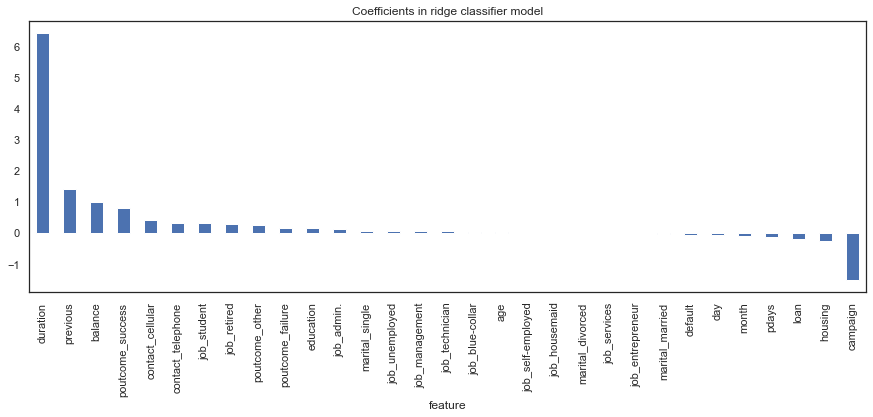

In [85]:
coef_ridge = pd.DataFrame({'feature': col_features, 'coef': clf_ridge.best_estimator_.coef_[0]})\
    .sort_values('coef', ascending=False).reset_index(drop=True)
coef_ridge.plot(kind='bar', x='feature', y='coef',
                   title='Coefficients in ridge classifier model', legend=False, 
                   figsize=(15,5))

### 4.3 Neural Classifier

#### a) Training

In [86]:
params_nn = {'hidden_layer_sizes': [10, 20, 30, 50],
             'alpha': [0.01, 0.1, 1]
            }
clf_neural = GridSearchCV(MLPClassifier(random_state=1012, max_iter=1000, 
                                        learning_rate_init=0.001),
                      params_nn, cv=5, n_jobs=-1, scoring=MCC_scorer)

In [87]:
clf_neural.fit(X_train_scaled_sm, y_train_scaled_sm)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=1012),
             n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1],
                         'hidden_layer_sizes': [10, 20, 30, 50]},
             scoring=make_scorer(matthews_corrcoef))

In [88]:
clf_neural.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': 50}

In [89]:
# Best cross validation score
print(f'5-Fold cross validation score: {clf_neural.best_score_:.4f}')

5-Fold cross validation score: 0.7718


#### b) Performance on test set

In [90]:
pred_nn = clf_neural.predict(X_test_scaled)

In [91]:
print(classification_report(y_test, pred_nn))

              precision    recall  f1-score   support

           0       0.96      0.85      0.91      7985
           1       0.41      0.75      0.53      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.80      0.72      9043
weighted avg       0.90      0.84      0.86      9043



In [92]:
mcc_nn = matthews_corrcoef(y_test, pred_nn)
print(f'MCC of Neural Classifier: {mcc_nn:.4f}')

MCC of Neural Classifier: 0.4732


### 4.4 Random Forest

#### a) Training

In [93]:
params_rf = {'n_estimators': [200, 300, 500], 
             'criterion': ['gini', 'entropy'], 
             'max_depth': [3, 4, 5], 
             'max_samples': [0.8, None]}
clf_rf = GridSearchCV(RandomForestClassifier(random_state=1012, class_weight='balanced'),
                      params_rf, cv=5, n_jobs=-1, scoring=MCC_scorer)

In [94]:
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1012),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5], 'max_samples': [0.8, None],
                         'n_estimators': [200, 300, 500]},
             scoring=make_scorer(matthews_corrcoef))

In [95]:
clf_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_samples': 0.8,
 'n_estimators': 200}

In [96]:
# Best cross validation score
print(f'5-Fold cross validation score: {clf_rf.best_score_:.4f}')

5-Fold cross validation score: 0.4835


#### b) Performance on test set

In [97]:
pred_rf = clf_rf.predict(X_test)

In [98]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7985
           1       0.37      0.85      0.52      1058

    accuracy                           0.81      9043
   macro avg       0.67      0.83      0.70      9043
weighted avg       0.91      0.81      0.84      9043



In [99]:
mcc_rf = matthews_corrcoef(y_test, pred_rf)
print(f'MCC of Random Forest: {mcc_rf:.4f}')

MCC of Random Forest: 0.4775


### 4.5 Grandient Boosting

#### a) Training

In [100]:
params_gb = {'subsample': [0.8, 1.0],
             'max_depth': [3, 4]}
clf_gb = GridSearchCV(GradientBoostingClassifier(n_estimators=300, learning_rate=0.1,
                                                 random_state=1012),
                      params_gb, cv=5, n_jobs=-1, scoring=MCC_scorer)

In [101]:
clf_gb.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=300,
                                                  random_state=1012),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4], 'subsample': [0.8, 1.0]},
             scoring=make_scorer(matthews_corrcoef))

In [102]:
clf_gb.best_params_

{'max_depth': 4, 'subsample': 1.0}

In [103]:
# Best cross validation score
print(f'5-Fold cross validation score: {clf_gb.best_score_:.4f}')

5-Fold cross validation score: 0.8457


#### b) Performance on test set

In [104]:
pred_gb = clf_gb.predict(X_test)

In [105]:
print(classification_report(y_test, pred_gb))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.58      0.52      0.55      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.74      0.75      9043
weighted avg       0.90      0.90      0.90      9043



In [106]:
mcc_gb = matthews_corrcoef(y_test, pred_gb)
print(f'MCC of Gradient Boosting: {mcc_gb:.4f}')

MCC of Gradient Boosting: 0.4962


#### c) Feature Importance in model

<AxesSubplot:title={'center':'Feature Importances in Gradient Boosting Model'}, xlabel='feature'>

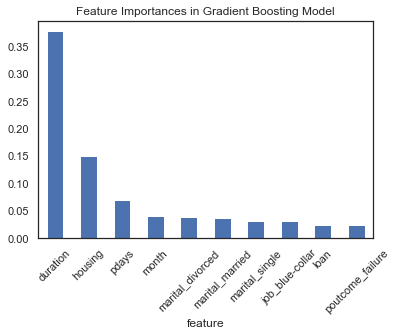

In [107]:
# Get the feature importance from grandient boosting classifier
feature_importances = pd.DataFrame({'feature': col_features, 'importance': clf_gb.best_estimator_.feature_importances_})\
    .sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances.iloc[0:10, :].plot(kind='bar', x='feature', y='importance', rot=45,
                                       title='Feature Importances in Gradient Boosting Model', legend=False)

## 5. Summary
- Using ROC and MCC value to compare the performance of above algorithms
- Among all the algorithms, Gradient Boosting is the best algorithm with highest ROC AUC and MCC value.

### 5.1 ROC Curve

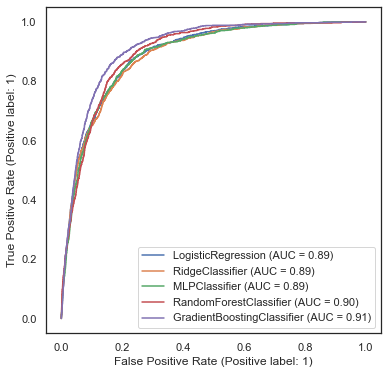

In [108]:
f, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(clf_logistic.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_ridge.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_neural.best_estimator_, X_test_scaled, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_rf.best_estimator_, X_test, y_test, pos_label=1, ax=ax)
plot_roc_curve(clf_gb.best_estimator_, X_test, y_test, pos_label=1, ax=ax)
plt.legend(loc='best')
plt.show()

### 5.2 MCC

In [109]:
classifier_names = ['Logistic Regression', 'Ridge Classifier', 'Neural Classifier', 
                    'Random Forest', 'Gradient Boosting']
MCC_scores = [mcc_logistic, mcc_ridge, mcc_nn, mcc_rf, mcc_gb]
pd.DataFrame({'Classifier': classifier_names, 'MCC Score': MCC_scores})\
            .sort_values('MCC Score', ascending=False).reset_index(drop=True)

,Classifier,MCC Score
0,Gradient Boosting,0.496184
1,Random Forest,0.477529
2,Neural Classifier,0.473193
3,Logistic Regression,0.465375
4,Ridge Classifier,0.464229
